# Datalab

## Imports

In [1]:
import numpy as np
import pandas as pd
from datasets import Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import NearestNeighbors

from cleanlab.experimental.datalab.data_generation import create_data, plot_data
from cleanlab.experimental.datalab.datalab import Datalab

2023-01-10 21:15:43.347527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-10 21:15:43.347574: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading data

We'll use a toy-dataset that puts the sum of two floats into one of three bins. The dataset, including the ground-truth labels, is created with the following code:


In [2]:
data_dict = create_data()

X_train, noisy_labels, y_train_idx, noisy_labels_idx, X_out = (
    data_dict[key]
    for key in [
        "X_train", "noisy_labels", "y_train_idx", "noisy_labels_idx", "X_out"
    ]
)


0.902970297029703


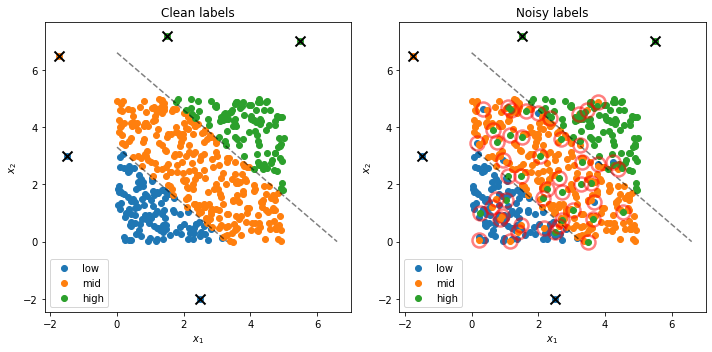

In [3]:
plot_data(X_train, y_train_idx, noisy_labels_idx, X_out)

In [4]:
# Wrap data in a Dataset object
data = Dataset.from_dict({"X": X_train, "y": noisy_labels})

## Get out-of-sample predicted probabilities from a classifier



In [ ]:
model = LogisticRegression()
pred_probs = cross_val_predict(
    estimator=model, X=data["X"], y=data["y"], cv=5, method="predict_proba"
)

## Instantiate a Datalab object

Provide the data object and a name of the label column in the data object.

Most issue types currently rely on getting (out-of-sample) predictions from a trained model.
We'll use a simple logistic regression model for this example.

In [ ]:
lab = Datalab(data, label_name="y")
lab.find_issues(pred_probs=pred_probs, features="X")

We can review some of the results:

In [ ]:
lab.report()

or view the issues directly:

In [ ]:
print("Summary")
display(lab.issue_summary)

print("Issues")
display(lab.issues)

## Incremental issue search

We can call `find_issues` multiple times on a Datalab object to find issues incrementally.

In [ ]:
lab = Datalab(data, label_name="y")
lab.find_issues(pred_probs=pred_probs, issue_types={"ood": {}})
lab.report()

In [ ]:
# Run the next check
lab.find_issues(pred_probs=pred_probs, issue_types={"label": {}})
lab.report()

In [ ]:
# Previous checks can be overwritten
lab.find_issues(pred_probs=pred_probs, features="X", issue_types={"ood": {}})
lab.report()

In [ ]:
lab.issue_summary

## Customizing hyperparameter in issue search

In this example, we'll use custom hyperparameters for the `"ood"` issue type.

In [ ]:
lab = Datalab(data, label_name="y")
knn = NearestNeighbors(n_neighbors=3, metric="euclidean")
issue_types = {"ood": {"ood_kwargs": {"params": {"knn": knn}}}}

lab.find_issues(
    pred_probs=pred_probs,
    features="X",
    issue_types=issue_types,
)
lab.report(k=10, verbosity=2)

Notice how last 5 examples correspond to the synthetic outliers we added to the data, which includes the two points that had a lower cosine distance in the previous ood-issue checks.

## Adding a custom IssueManager

In [ ]:
from cleanlab.experimental.datalab.issue_manager import IssueManager
from cleanlab.experimental.datalab.factory import register as register_issue_manager


def scoring_function(idx: int) -> float:
    if idx == 0:
        # Zero excluded from the divisibility check, gets the highest score
        return 1
    rem = idx % 13
    inv_scale = idx // 13
    if rem == 0:
        return 0.5 * (1 - np.exp(-0.1*(inv_scale-1)))
    else:
        return 1 - 0.49 * (1 - np.exp(-inv_scale**0.5))*rem/13


@register_issue_manager
class SuperstitionIssueManager(IssueManager):
    """A custom issue manager that keeps track of issue indices that
    are divisible by 13.
    """
    issue_name: str = "superstition"

    def find_issues(self, div=13, **_) -> None:
        ids = self.datalab.issues.index.to_series()
        issues_mask = ids.apply(lambda idx: idx % div == 0 and idx != 0)
        scores = ids.apply(scoring_function)
        self.issues = pd.DataFrame(
            {
                f"is_{self.issue_name}_issue": issues_mask,
                self.issue_score_key: scores,
            },
        )
        summary_score = 1 - sum(issues_mask) / len(issues_mask)
        self.summary = self.get_summary(score = summary_score)



In [ ]:
lab.find_issues(issue_types={"superstition": {}})
lab.report()

# Save the results

In [ ]:
path = "test-lab"

In [ ]:
lab.save(path)

In [ ]:
lab.info

# Load the Datalab


In [ ]:

new_lab = Datalab.load(path)

In [ ]:
new_lab.info